In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We can load the images from the disk using just a few lines of code using the tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on a disk to a tf.data.Dataset. 

In [28]:
data_dir = "/Users/esbishop/Sea_snakes_images/Images"   # Path to image directory

In [29]:
# We need to define some parameters for the laoder: 
batch_size = 32
img_height = 180
img_width = 180

In [44]:
# It's good practice to use a validation split when developing a model. Let's use 80% of the images for training, 
# and 20% for validation. 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1370 files belonging to 2 classes.
Using 1096 files for training.


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1370 files belonging to 2 classes.
Using 274 files for validation.


In [32]:
# We can have a look at the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order. 
class_names = train_ds.class_names
print(class_names)

['rope', 'snake']


2022-01-17 13:41:43.566711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-17 13:41:43.569829: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-17 13:41:53.588835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 229 of 256
2022-01-17 13:41:54.500555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


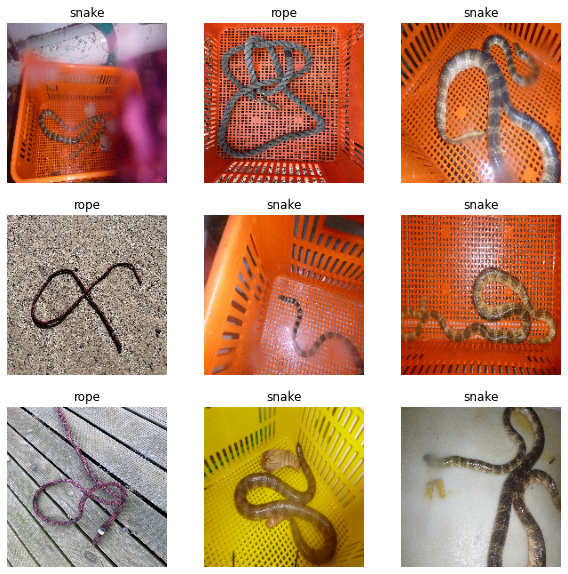

In [7]:
# We can have a look at the first 9 images from the training dataset: 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [86]:
# We will train a model using these datasets by passing them to Model.fit. We can also manually iterate over the 
# dataset and retreive batches on images:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Configure the Dataset for performance

Let's make sure to use buffered prefetching so you can yeild data from disk without haveing I/O become blocking. These are two important methods you should use when loading data: 
- Dataset.cache keeps the images in memory after theyre loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If your dataset is too large to fit in memory, you can also use this method to create a performant on-disk cache. 
- Dataset.prefetch overlaps data preprocessing and model execution while training. 

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardise the data 

The RGB colour channels are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. 

Here, we will standardise values to be in the [0,1] range by using tf.keras.layers.Rescaling

In [34]:
normalization_layer = layers.Rescaling(1./255) # We can include this layer in the model definition 

In [35]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

We choose the tf.keras.optimizers.Adam optimiser and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile. 

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
# View all layers of the network using the model's Model.summary method: 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

### Train the model

In [38]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-01-17 13:59:33.412966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-17 13:59:44.904142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-01-17 13:59:54.670695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 9 of 1000
2022-01-17 14:00:03.632120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 16 of 1000
2022-01-17 14:00:14.486752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 25 of 1000
2022-01-17 14:00:15.934522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.7901

2022-01-17 14:00:18.509798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-17 14:00:28.598088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-17 14:00:28.867319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 57s 404ms/step - loss: 0.4937 - accuracy: 0.7901 - val_loss: 0.3707 - val_accuracy: 0.8248
Epoch 2/20
35/35 [==============================] - 2s 71ms/step - loss: 0.1562 - accuracy: 0.9416 - val_loss: 0.0903 - val_accuracy: 0.9672
Epoch 3/20
35/35 [==============================] - 2s 68ms/step - loss: 0.1017 - accuracy: 0.9608 - val_loss: 0.1022 - val_accuracy: 0.9562
Epoch 4/20
35/35 [==============================] - 2s 69ms/step - loss: 0.0654 - accuracy: 0.9808 - val_loss: 0.0587 - val_accuracy: 0.9818
Epoch 5/20
35/35 [==============================] - 2s 67ms/step - loss: 0.0363 - accuracy: 0.9881 - val_loss: 0.0401 - val_accuracy: 0.9854
Epoch 6/20
35/35 [==============================] - 2s 68ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0309 - val_accuracy: 0.9964
Epoch 7/20
35/35 [==============================] - 2s 69ms/step - loss: 0.0160 - accuracy: 0.9936 - val_loss: 0.0517 - val_accuracy: 0.9818
Epoch 8/20
35/35 [====

### Visulaise the training results

Create plots of loss and accuracy on the training and validation sets: 

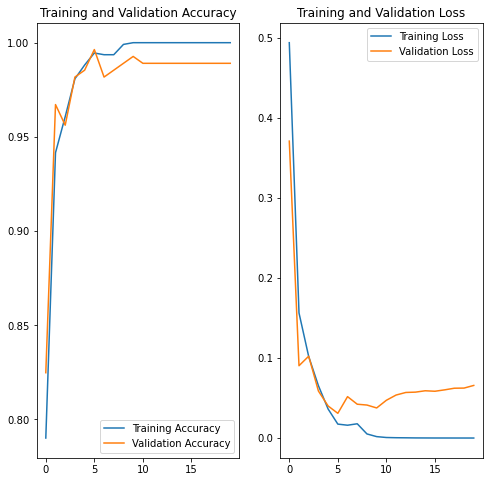

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
#print(dir())

['AUTOTUNE', 'In', 'Out', 'PIL', 'Sequential', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'acc', 'ax', 'batch_size', 'class_names', 'data_dir', 'epochs', 'epochs_range', 'exit', 'get_ipython', 'history', 'i', 'image_batch', 'images', 'img_height', 'img_width', 'keras', 'labels', 'labels_batch', 'layers', 'loss', 'model', 'normalization_layer', 'np', 'num_classes', 'os', 'plt', 'quit', 'tf', 'train_ds', 'val_acc', 'val_ds', 'val_loss']


In [26]:
#for element in dir():
#    if element[0:2] != "__":
#        del globals()[element]

#del element
#print(dir())

['__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__']


Attempts to augment data:

In [88]:
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

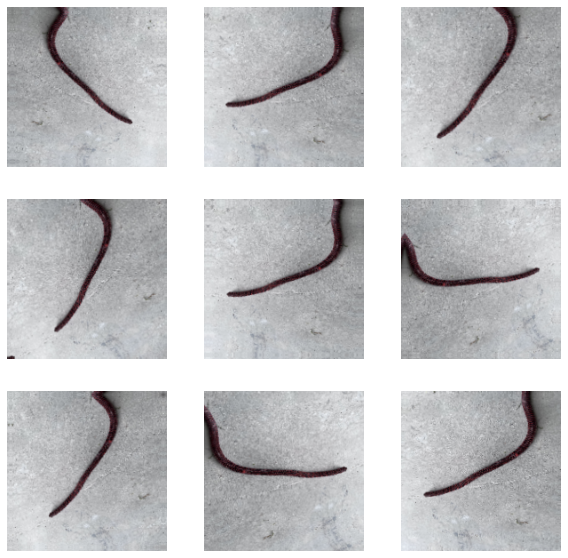

In [89]:
with tf.device('/CPU:0'):
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")
 

### Dropout
Another technique to reduce overfitting is to introduce dropout regularisation to the network. 

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during teh training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20%, or 40% of the output units randomly from the applied layer. 

We'll create a new neural network with tf.keras.layers.dropout. 

In [90]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [91]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

In [93]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2022-01-17 16:18:01.429865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 0.9681 - accuracy: 0.6131

2022-01-17 16:18:38.455117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 38s 799ms/step - loss: 0.9681 - accuracy: 0.6131 - val_loss: 0.4413 - val_accuracy: 0.8796
Epoch 2/15
35/35 [==============================] - 36s 791ms/step - loss: 0.2949 - accuracy: 0.8841 - val_loss: 0.0946 - val_accuracy: 0.9599
Epoch 3/15
35/35 [==============================] - 38s 823ms/step - loss: 0.1336 - accuracy: 0.9489 - val_loss: 0.0889 - val_accuracy: 0.9635
Epoch 4/15
35/35 [==============================] - 36s 783ms/step - loss: 0.0856 - accuracy: 0.9672 - val_loss: 0.1179 - val_accuracy: 0.9672
Epoch 5/15
35/35 [==============================] - 36s 782ms/step - loss: 0.0720 - accuracy: 0.9790 - val_loss: 0.2339 - val_accuracy: 0.9270
Epoch 6/15
35/35 [==============================] - 36s 792ms/step - loss: 0.0620 - accuracy: 0.9808 - val_loss: 0.2118 - val_accuracy: 0.9453
Epoch 7/15
35/35 [==============================] - 36s 787ms/step - loss: 0.0579 - accuracy: 0.9799 - val_loss: 0.0944 - val_accuracy: 0.9745
Epoch 8/15

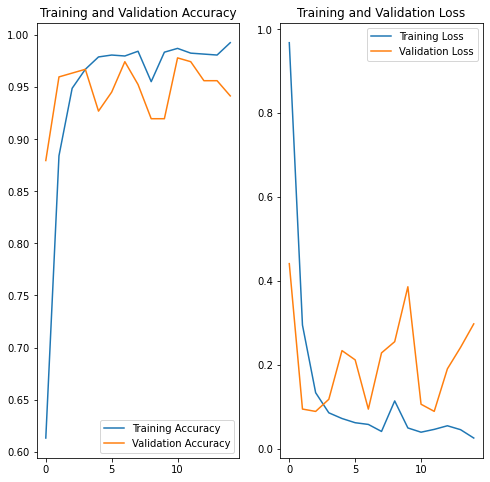

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()